In [1]:
import pickle 
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import SimilarityMaps
from fp_xai import get_weights_for_visualization, get_contour_image, mol2fp, AAU_weights, UAA_weights

### Download and read model

9 random forest models are available here: [RF_models](https://sid.erda.dk/sharelink/eUVFpTDU62)

Download one of the models or train your own. 

Here we use the biggest model trained on 150.000 entries

In [2]:
m = pickle.load(open("150000_200_3_2048.p", 'rb'))
m

RandomForestRegressor(min_samples_leaf=3, n_estimators=200)

### Contour plots  - logP predictions

We can create contour plots for 

- the ML atomic attributions using the ”atom attribution from finger prints”-method developed by Riniker and Landrum (ml_weights)
- The Crippen logP atomic attributions (atom_weights)
- Finger print adjusted (FPA) Crippen logP atomic attributions (fpa_weights)

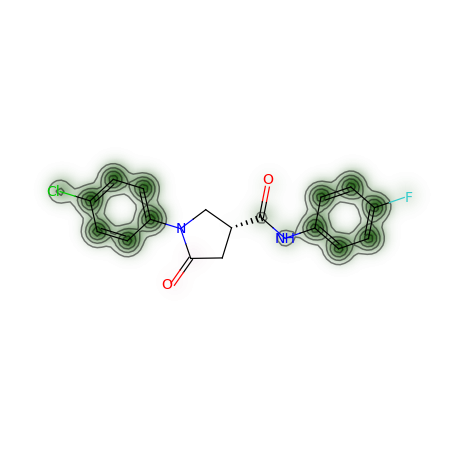

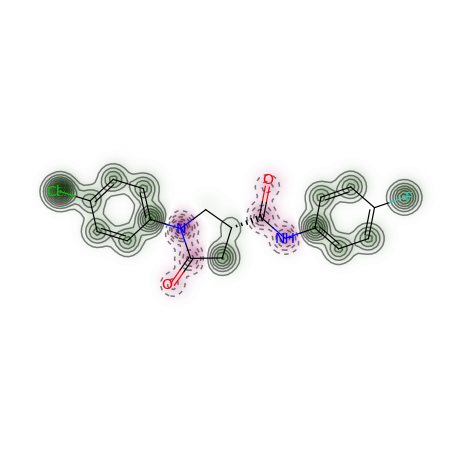

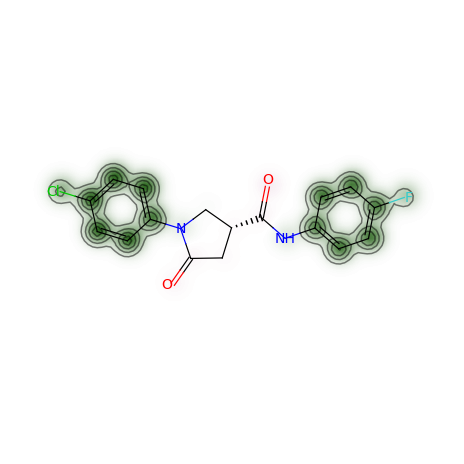

In [3]:
smiles = "O=C(Nc1ccc(F)cc1)[C@@H]1CC(=O)N(c2ccc(Cl)cc2)C1"
mol = Chem.MolFromSmiles(smiles)
ml_weights, atom_weights, fpa_weights = get_weights_for_visualization(mol, m, radius=2, n_bits=2048)
fig_ml = get_contour_image(mol, ml_weights)
fig_atomic = get_contour_image(mol, atom_weights)
fig_fpa = get_contour_image(mol, fpa_weights)

We use the overlaps of the normalized attribution vector to quantify how well the attribution vectors match, for the current example:

In [4]:
ml_atom_overlap = ml_weights/np.linalg.norm(ml_weights)@atom_weights/np.linalg.norm(atom_weights)
print("overlap between ML attribution vector and Crippen logP atomic ground truth = ", ml_atom_overlap)
ml_fpa_overlap = ml_weights/np.linalg.norm(ml_weights)@fpa_weights/np.linalg.norm(fpa_weights)
print("overlap between ML attribution vector and FPA ground truth = ", ml_fpa_overlap)

overlap between ML attribution vector and Crippen logP atomic ground truth =  0.6624334869514825
overlap between ML attribution vector and FPA ground truth =  0.9887713731764111


### Uncertainties
The uncertainty on the prediction is calculated as the standard deviation of the individual tree predictions

In [5]:
ecfp2_fingerprint = mol2fp(mol, radius=2, n_bits=2048)
print("logP predictions =", m.predict([ecfp2_fingerprint]))
tree_predictions = []
for tree in m.estimators_:
    tree_predictions.append(tree.predict([ecfp2_fingerprint]))

uncertainties = np.std(np.array(tree_predictions), axis=0)
print("uncertainties = ", uncertainties)

logP predictions = [3.79304177]
uncertainties =  [0.63979375]


### Uncertainty in the Atom Attribution (UAA) 
The UAA contour plots are created by calculating the standard deviation of individual tree-attributions to logP
The attributions are scaled to zero-point is at 0.3 and each contour represent a approx. 0.2 change

In [6]:
uaa_weights = UAA_weights(mol, m, radius=2, n_bits=2048)

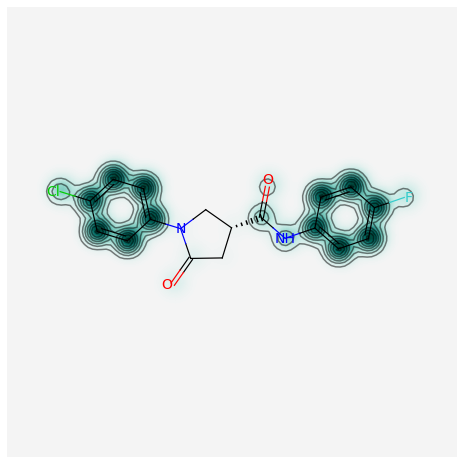

In [10]:
uaa_weights = uaa_weights-0.3
contour_step=0.2
N_contour = (max(uaa_weights)-min(uaa_weights))/contour_step
fig_uaa = SimilarityMaps.GetSimilarityMapFromWeights(mol, uaa_weights, colorMap='BrBG', contourLines=round(N_contour))

### Atomic Attribution to the Uncertainty (AAU) 
The AAU contour plots are created by calculating the change in predicted uncertainty when removing bits related to individual atoms.
The attributions are scaled to be positive (minimum AAU is set to 0) and the sum of attributions scaled to the predicted uncertainty

In [11]:
aau_weights = AAU_weights(mol, m, radius=2, n_bits=2048)
aau_weights = aau_weights - min(aau_weights)
aau_weights = aau_weights*uncertainties[0]/np.sum(aau_weights)

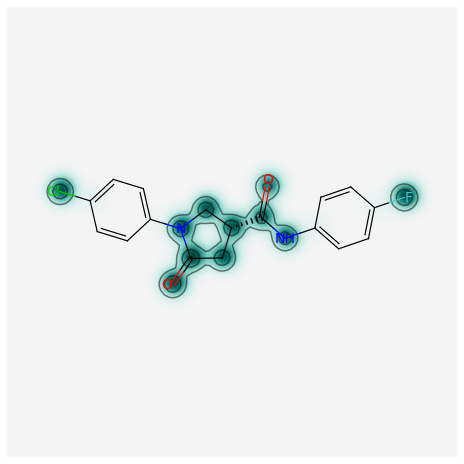

In [12]:
contour_step=0.02
N_contour = (max(aau_weights)-min(aau_weights))/contour_step
fig_uaa = SimilarityMaps.GetSimilarityMapFromWeights(mol, aau_weights, colorMap='BrBG', contourLines=round(N_contour))